            P_i          P_f  energy_i    energy_f
0       6500204     6.500615       0.0    0.000301
1       6469330     6.469827       0.0    0.000600
2       6709821     6.710363       0.0    0.000913
3       6587499     6.587929       0.0    0.001217
4       6466867     6.467294       0.0    0.001847
5       6625271     6.625806       0.0    0.002552
6       6759273     6.759954       0.0    0.002865
7       6371496     6.371983       0.0    0.003454
8       6462034     6.462629       0.0    0.003753
9       6503269     6.503587       0.0    0.004355
10      6264430     6.265119       0.0    0.004647
11      4806881     4.807488       0.0    0.005113
12      4279715     4.280068       0.0    0.005530
13      4410748     4.411198       0.0    0.005734
14      4698818     4.699230       0.0    0.006170
15      4431823     4.432294       0.0    0.006601
16      4904547     4.904976       0.0    0.006828
17      4530281     4.530621       0.0    0.007269
18      5059653     5.060101   

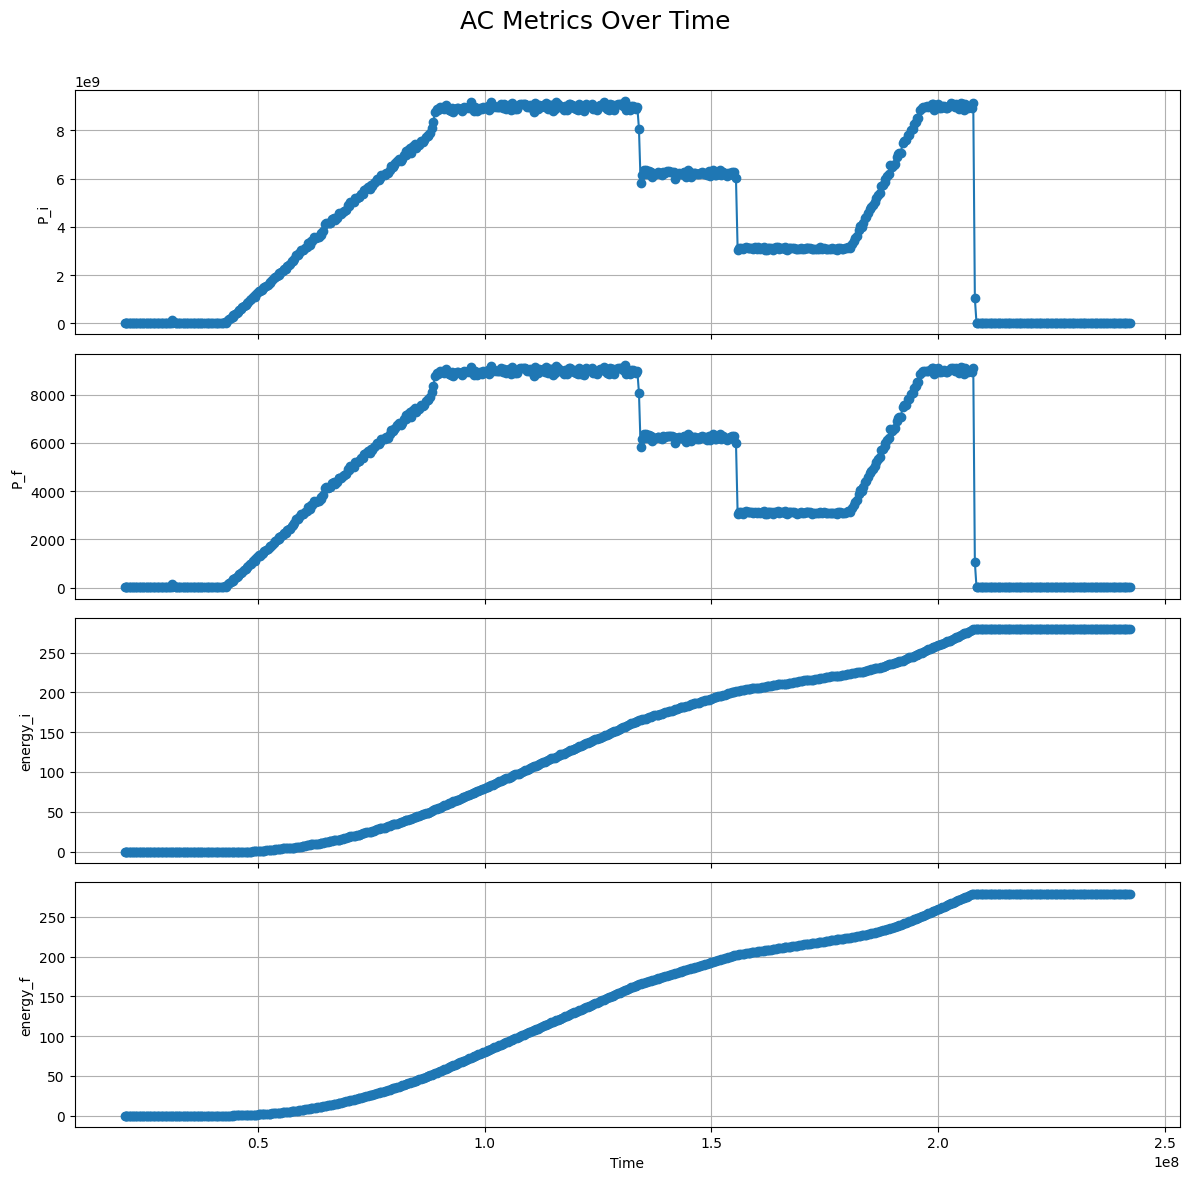

In [23]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def ADS_raw24sInt_to_mV(raw):
    return raw * 512 / (2**23)
def AC_V_from_mV(AC_V_mV):
    return AC_V_mV / 1.009
def AC_I_from_mV(AC_I_mV):
    return AC_I_mV / 3.12 #3.12 = 7.8/2.5 AX80 burden resistor / divider ratio/1000
def AC_V_from_raw(raw):
    return AC_V_from_mV(ADS_raw24sInt_to_mV(raw))
def AC_I_from_raw(raw):
    return AC_I_from_mV(ADS_raw24sInt_to_mV(raw))

# Constants
ADS_FULL_SCALE = 8388608          # 2^23
ADS_SCALE_FACTOR = 512            # (2048 mV / Gain 4)
AC_V_RESISTOR_RATIO = 991         # AC mV = ratio * ADS input mV
x1000_CT_ratio_divBy_burdenResistance = 320512  # example: ax80 206,954 ax48

def AC_V_mV_from_raw(raw: int) -> int:
    """
    Convert ADS1220 raw reading to AC voltage in millivolts.
    """
    temp = int(raw) * ADS_SCALE_FACTOR * AC_V_RESISTOR_RATIO
    # integer rounding
    return int((temp + (ADS_FULL_SCALE // 2)) // ADS_FULL_SCALE)

def AC_I_mA_from_raw(raw: int) -> int:
    """
    Convert ADS1220 raw reading to AC current in milliamps.
    """
    temp = int(raw) * ADS_SCALE_FACTOR * x1000_CT_ratio_divBy_burdenResistance
    # integer rounding
    return int((temp + (ADS_FULL_SCALE // 2)) // (ADS_FULL_SCALE * 1000))

def AC_P_uW_from_raw(raw: int) -> int:
    """
    Convert 24-bit*24-bit raw product to power in microwatts (µW).
    """
    # Step 1: divide early to prevent oversized intermediate
    scaled = (x1000_CT_ratio_divBy_burdenResistance * raw) // ADS_FULL_SCALE
    scaled = (scaled * AC_V_RESISTOR_RATIO) // 1000
    scaled = (scaled * ADS_SCALE_FACTOR * ADS_SCALE_FACTOR) // ADS_FULL_SCALE

    return scaled  # µW

def energy_uWh_from_uW_us(power_uW: int, time_us: int) -> int:
    """
    Convert power in µW and duration in microseconds to energy in µWh.
    """
    # Multiply first; safe for inputs up to ~10^13 and ~10^6 respectively
    energy_uWus = power_uW * time_us

    # Convert to µWh (1 hour = 3.6e9 µs)
    return energy_uWus // 3_600_000_000




def compute_negToPos_zero_crossings(t, v):
    crossings = []
    for i in range(len(v) - 1):
        if v[i] < 0 and v[i+1] >= 0:  # Positive-going
            # Linear interpolation to estimate crossing time
            slope = v[i+1] - v[i]
            if slope == 0:
                continue  # avoid divide by zero
            t_cross = t[i] - v[i] * (t[i+1] - t[i]) / slope
            # crossings.append(t_cross)
            crossings.append(i) # no linear interpolation
            #####
            ##
    return np.array(crossings)

def analyze_ac(df, v_col='v', i_col='i', i_i_col='I_int', t_col='time'):
    v = df[v_col].to_numpy()
    i = df[i_col].to_numpy()
    i_i = df[i_i_col].to_numpy()
    t = df[t_col].to_numpy()

    # Zero crossings indices (positive-going) for voltage and current
    v_zc = compute_negToPos_zero_crossings(t, v)
    i_zc = compute_negToPos_zero_crossings(t, i)

    if len(v_zc) < 2 or len(i_zc) < 1:
        raise ValueError("Not enough zero crossings detected.")

    # Frequency estimation using voltage zero crossings
    periods = np.diff(t[v_zc])
    avg_period = np.mean(periods)
    freq = 1.0 / avg_period

    # --- RMS Calculations ---
    
    Vrms = np.sqrt(np.mean(v**2)) # no high pass filter

    mean_sq = np.sum(v.astype(np.int64) ** 2) // len(v)
    VrmsI = int(np.sqrt(mean_sq))  # final RMS as int

    
    
    Irms = np.sqrt(np.mean(i**2))

    mean_sq = np.sum(i_i.astype(np.int64) ** 2) // len(v)
    IrmsI = int(np.sqrt(mean_sq))  # final RMS as int

    # --- Real Power & Power Factor ---
    P = np.mean(v * i)          # Real power (W)
    P_i = np.sum(v.astype(np.int64) * i_i.astype(np.int64)) // len(v)

    S = Vrms * Irms             # Apparent power (VA)
    pf = P / S if S != 0 else 0
    phase_angle_rad_mag = np.arccos(np.clip(pf, -1.0, 1.0))

    # --- Phase angle sign from zero crossing difference using time ---
    v_first_zc_time = t[v_zc[0]]
    i_first_zc_time = t[i_zc[0]]

    time_diff = i_first_zc_time - v_first_zc_time  # seconds

    # Calculate phase angle in degrees
    phase_angle_deg = 360 * time_diff / avg_period

    # Adjust sign based on zero crossing order
    if time_diff < 0:
        # Current zero crossing before voltage → current leads voltage (capacitive)
        phase_angle_deg = -abs(phase_angle_deg)
    else:
        # Current zero crossing after voltage → current lags voltage (inductive)
        phase_angle_deg = abs(phase_angle_deg)

    phase_angle_rad = np.radians(phase_angle_deg)

    return {
        "Vrms": Vrms,
        "VrmsI": VrmsI,
        "Irms": Irms,
        "IrmsI": IrmsI,
        "Real Power (W)": P,
        "PowerI": P_i,
        "Apparent Power (VA)": S,
        "Power Factor": pf,
        "PF (rad)": phase_angle_rad_mag,
        "Phase Angle (deg)": phase_angle_deg,
        "Phase Angle (rad)": phase_angle_rad,
        "freq": freq
    }




file_path = "F150_July25_raw1.csv"
data = []

# Parse only V/I lines
with open(file_path, 'r') as f:
    for line in f:
        parts = line.strip().split(',')
        if len(parts) >= 3 and parts[1].strip() in ['V', 'I']:
            try:
                timestamp = int(parts[0])
                value = int(parts[2])
                label = parts[1].strip()
                data.append({'time': timestamp, 'type': label, 'value': value})
            except ValueError:
                continue  # skip bad lines

# Build DataFrame
df = pd.DataFrame(data)

df = df.copy()

prev_I = df['value'].shift(1).where(df['type'].shift(1) == 'I')
next_I = df['value'].shift(-1).where(df['type'].shift(-1) == 'I')

mask = (df['type'] == 'V') & prev_I.notna() & next_I.notna()
df.loc[mask, 'I'] = (prev_I + next_I) / 2


df = df[df['type'] == 'V']
df = df.reset_index(drop=True)
df = df.drop(columns='type')         # Remove 'type' column
df = df.rename(columns={'value': 'V'})  # Rename 'value' to 'V'

df = df.dropna()

df['I_int'] = df['I'].round().astype('Int64')
# print(df)

new_df = []


# df['AC_V'] = AC_V_from_raw(df['V'])
# df['AC_I'] = AC_I_from_raw(df['I'])





zcs = compute_negToPos_zero_crossings(df['time'].to_numpy(), df['V'].to_numpy())

i = 0
# print(zcs)
energy_f = 0
energy_i = 0



ac_df = pd.DataFrame()
while(1):
    if i+10 > len(zcs) - 1:
        break
    # print(f'--10cycleChunk--{i//10}')
    start, end = zcs[i], zcs[i+10] # samples before 1st zc, 11th zc
    # print(start + 1,end)
    i += 10
    tempdf = df.iloc[start + 1 : end + 1]  #sample after 1st zc : sample before 11th zc


    results = analyze_ac(tempdf, v_col='V', i_col='I', i_i_col='I_int', t_col='time')






    results['time'] = df.iloc[end]['time']

    results['Vrms_f'] = AC_V_from_raw(results['Vrms']) * 1000
    results['Vrms_i'] = AC_V_mV_from_raw(results['VrmsI'])

    results['Irms_f'] = AC_I_from_raw(results['Irms']) * 1000
    results['Irms_i'] = AC_I_mA_from_raw(results['IrmsI'])



    results['P_f'] = AC_I_from_raw(AC_V_from_raw(results['Real Power (W)']))
    results['P_i'] = AC_P_uW_from_raw(results['PowerI'])

    results['Power_pct_diff'] = (
        (results['P_f'] - results['P_i']) / results['P_f']
    ) * 100

    

    timeElapsed = (df.iloc[end]['time'] - df.iloc[start]['time'])
    # print(df.iloc[end]['time'], df.iloc[start]['time'])
    energy_i += energy_uWh_from_uW_us(results['P_i'], timeElapsed)
    energy_f += (results['P_f'] * timeElapsed) / (3.6 * 10**6)

    results['energy_i'] = energy_i
    results['energy_f'] = energy_f


    row_df = pd.DataFrame([results])
    ac_df = pd.concat([ac_df, row_df], ignore_index=True)




ac_df['energy_f'] = ac_df['energy_f']/1000

ac_df['energy_i'] = ac_df['energy_i']//1000000 


cols_to_print = [
    # 'Vrms_f', 'Vrms_i', 'Irms_f', 'Irms_i',
    # 'Vrms_pct_diff'
    "P_i", "P_f",
    'energy_i', 'energy_f'
]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ac_df[cols_to_print])


# List of metrics to plot
x = ac_df['time']
metrics = [
    # "Vrms_f","Vrms_i",
    # "Irms_f", "Irms_i",
    "P_i", "P_f",
    'energy_i', 'energy_f'
]



# Create subplots for each metric
fig, axs = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, 3 * len(metrics)), sharex=True)
fig.suptitle("AC Metrics Over Time", fontsize=18)

# Plot each metric
for i, key in enumerate(metrics):
    axs[i].plot(x, ac_df[key], marker='o', linestyle='-')
    axs[i].set_ylabel(key)
    axs[i].grid(True)

# Label only the last subplot with x-axis
axs[-1].set_xlabel("Time")

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for title
plt.show()


